# Imports

In [1]:
from importlib import reload
import mst_mach_211028_v2 as mst

reload(mst)

import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import MDSplus as mds
import pandas as pd
import numpy as np
import numpy.linalg as nl
from scipy.optimize import curve_fit
from matplotlib.ticker import EngFormatter

import tqdm

# set contants

In [2]:
time_formatter = EngFormatter('s')
current_formatter = EngFormatter('A')

In [3]:
comp='dave'
tree = 'mst'
probe_name = 'probe3_'
tips = range(1, 8)
coils = range(8, 11)
shot_null = 1210818000

mst_ops_node_paths = {"f": "\mst_ops::f", 
                      "ip": "\mst_ops::ip",
                      "btw": "\mst_ops::btw",
                      "btave": "\mst_ops::btave"}

mst_btwf_node_paths = {"btw_f": "\mst_ops::btw_f"}

mst_ne_path = {"ne": "\mst_fir::fir_fast_p06"}

# Setup Functions

In [4]:
shot_file = "octahedral prototype commissioning - 2021-08 - shot settings.xlsx"
compressed_shot_settings = pd.read_excel(shot_file, skiprows=2, header=0)
shot_settings = []
for i, shot in enumerate(compressed_shot_settings['Shots']): 
    if str(shot) == 'nan':
        continue
    if '-' not in shot:
        shot_settings.append(compressed_shot_settings.iloc[i].to_dict())
    if '-' in shot:
        shot_start, shot_end = shot.split('-')
        date = shot_start[:-3]
        start = shot_start[-3:]
        for j in range(int(start), int(shot_end) + 1):
            shot_to_save = date + str(j).zfill(3)
            settings = compressed_shot_settings.iloc[i].to_dict()
            settings['Shots'] = shot_to_save
            shot_settings.append(settings)
shot_settings = pd.DataFrame(shot_settings)

In [6]:
def mst_ops(shot):
    server = comp + '.physics.wisc.edu'
    conn = mds.Connection(server)
    conn.openTree(tree, shot)
    ref_node_path = mst_ops_node_paths[list(mst_ops_node_paths.keys())[0]]
    ref_time = np.asarray(conn.get('DIM_OF(' + ref_node_path + ')'))
    ref_time = ref_time.astype("float64")
    ops = {}
    for key in mst_ops_node_paths.keys():
        node = conn.get(mst_ops_node_paths[key])
        data = node.data()
        time = np.asarray(conn.get('DIM_OF(' + mst_ops_node_paths[key] + ')'))
        data = data.astype("float64")
        time = time.astype("float64")
        assert np.allclose(time, ref_time), "time bases differ"
        ops[key] = data
    return ops, time

In [7]:
def mst_btwf(shot):
    server = comp + '.physics.wisc.edu'
    conn = mds.Connection(server)
    conn.openTree(tree, shot)
    ref_node_path = mst_btwf_node_paths[list(mst_btwf_node_paths.keys())[0]]
    ref_time = np.asarray(conn.get('DIM_OF(' + ref_node_path + ')'))
    ref_time = ref_time.astype("float64")
    ops = {}
    for key in mst_btwf_node_paths.keys():
        node = conn.get(mst_btwf_node_paths[key])
        data = node.data()
        time = np.asarray(conn.get('DIM_OF(' + mst_btwf_node_paths[key] + ')'))
        data = data.astype("float64")
        time = time.astype("float64")
        assert np.allclose(time, ref_time), "time bases differ"
        ops[key] = data
    return ops, time

In [8]:
def mst_ne(shot):
    server = comp + '.physics.wisc.edu'
    conn = mds.Connection(server)
    conn.openTree(tree, shot)
    ref_node_path = mst_ne_path[list(mst_ne_path.keys())[0]]
    ref_time = np.asarray(conn.get('DIM_OF(' + ref_node_path + ')'))
    ref_time = ref_time.astype("float64")
    ops = {}
    for key in mst_ne_path.keys():
        node = conn.get(mst_ne_path[key])
        data = node.data()
        time = np.asarray(conn.get('DIM_OF(' + mst_ne_path[key] + ')'))
        data = data.astype("float64")
        time = time.astype("float64")
        assert np.allclose(time, ref_time), "time bases differ"
        ops[key] = data
    return ops, time

In [9]:
def build_ops_ds(shots):
    ref_data, ref_time = mst_ops(1210818038)
    ds = xr.Dataset(
                    data_vars={
                               key: (
                                     ["shot", "time"],
                                     np.array([mst_ops(shot_null + shot)[0][key] for shot in shots]),
                                    )
                                for key in ref_data.keys()
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [10]:
def build_btwf_ds(shots):
    ref_data, ref_time = mst_btwf(1210818038)
    ds = xr.Dataset(
                    data_vars={
                               key: (
                                     ["shot", "time"],
                                     np.array([mst_btwf(shot_null + shot)[0][key] for shot in shots]),
                                    )
                                for key in ref_data.keys()
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [11]:
def build_ne_ds(shots):
    ref_data, ref_time = mst_ne(1210818038)
    ds = xr.Dataset(
                    data_vars={
                               key: (
                                     ["shot", "time"],
                                     np.array([mst_ne(shot_null + shot)[0][key] for shot in shots]),
                                    )
                                for key in ref_data.keys()
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [12]:
def shot_data(shot, node, ref_time=None):
    r'''
    '''
    server = comp + '.physics.wisc.edu'
    conn = mds.Connection(server)
    conn.openTree(tree, shot)
    signalname = '\\' + probe_name + str(node).zfill(2)
    node = conn.get(signalname)
    data = node.data()
    time = np.asarray(conn.get('DIM_OF(' + signalname + ')'))
    data = data.astype('float64')
    time = time.astype('float64')
    if not ref_time is None:
        assert np.allclose(time, ref_time), 'time not equal'
    return data, time

In [13]:
def build_b_dataset(shots):
    
    ref_data, ref_time = shot_data(1210818038, 1)  
    
    
    ds = xr.Dataset(
                    data_vars={
                               'B'+str(i+1): (
                                     ["shot", "time"],
                                     np.array([shot_data(shot_null + shot, coil, ref_time=ref_time)[0] for shot in shots]),
                                    )
                                for i, coil in enumerate(coils)
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [14]:
def build_dataset(shots):
    
    ref_data, ref_time = shot_data(1210818038, 1)  
    
    
    ds = xr.Dataset(
                    data_vars={
                               'Isat'+str(tip): (
                                     ["shot", "time"],
                                     np.array([shot_data(shot_null + shot, tip, ref_time=ref_time)[0] for shot in shots]),
                                    )
                                for tip in tips
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [15]:
def build_rj_dataset(shots):
    r"""
    Build xarray of rj values.
    """
    ds = xr.Dataset(
                    data_vars={
                               'Isat'+str(tip): (
                                    ["shot"],
                                    np.asarray([shot_settings[f'RJ{tip} (Ohm)'].iloc[[shot]].values for shot in shots])[:, 0],
                                    )
                               for tip in tips
                              },
                              coords={"shot": ("shot", shots)},        
    )
    return ds

In [16]:
def remove_offset(data, bk_start=-0.015, bk_end=-0.001):
    data = data - data.sel(time=slice(bk_start, bk_end)).mean()
    return data

In [17]:
def box_filter(data, points=50):
    box = np.ones(points)/points
    data_smooth = np.convolve(data, box, mode='same')
    return data_smooth

In [18]:
mst_ds = build_ops_ds(range(1, 11))

# Read datasets

In [19]:
mst_ds = build_ops_ds(range(1, 83))
mst_ds.to_netcdf('data_backup/mst_ds.nc')

In [20]:
ds_B = build_b_dataset(range(1, 83))
ds_B.to_netcdf('data_backup/ds_B.nc')

In [21]:
mst_ne_ds = build_ne_ds(range(11, 83))
mst_ne_ds.to_netcdf('data_backup/mst_ne_ds.nc')

In [23]:
mst_btwf_ds = build_btwf_ds(range(11, 83))
mst_btwf_ds.to_netcdf('data_backup/mst_btwf_ds.nc')

# Smoothing

In [24]:
def convolve(data, width):
    #print(data, width)
    box = np.ones(width)/width
    return np.convolve(data, box, 'same')

In [25]:
shot_settings['RJ7 (Ohm)'] = shot_settings['RJ return']
ds_raw = build_dataset(range(11, 50))
ds_raw = ds_raw.sel(time=(slice(-0.01, 75e-3)), 
                          shot=slice(30, 39))
ds_smooth = xr.apply_ufunc(convolve, ds_raw.groupby('shot'), 100)
rjs = build_rj_dataset(range(11, 50))
ds_I_off = ds_smooth/rjs
ds_I = ds_I_off - ds_I_off.sel(time=slice(-0.015, -0.001)).mean(dim='time')
ds_I = ds_I.assign_coords(ms=ds_I.time * 1e3)

ds_raw = build_dataset(range(11, 50))
ds_raw_all = ds_raw.sel(time=(slice(-0.01, 75e-3)), 
                        shot=slice(11, 50))
ds_smooth_all = xr.apply_ufunc(convolve, ds_raw_all.groupby('shot'), 100)
rjs = build_rj_dataset(range(11, 50))
ds_I_off_all = ds_smooth_all/rjs
ds_I_all = ds_I_off_all - ds_I_off_all.sel(time=slice(-0.015, -0.001)).mean(dim='time')
ds_I_all = ds_I_all.assign_coords(ms=ds_I_all.time * 1e3)

In [ ]:
ds_smoother = xr.apply_ufunc(convolve, ds_raw.groupby('shot'), 10000)
ds_I_off_smoother = ds_smoother/rjs
ds_I_smoother = ds_I_off_smoother - ds_I_off_smoother.sel(time=slice(-0.015, -0.001)).mean(dim='time')
ds_I_smoother = ds_I_smoother.assign_coords(ms=ds_I.time * 1e3)

In [26]:
ds_I_all

<xarray.Dataset>
Dimensions:  (time: 85000, shot: 39)
Coordinates:
  * time     (time) float64 -0.01 -0.009999 -0.009998 ... 0.075 0.075 0.075
  * shot     (shot) int64 11 12 13 14 15 16 17 18 19 ... 42 43 44 45 46 47 48 49
    ms       (time) float64 -10.0 -9.999 -9.998 -9.997 ... 75.0 75.0 75.0 75.0
Data variables:
    Isat1    (shot, time) float64 0.0008103 0.0007945 ... 0.000695 0.0007096
    Isat2    (shot, time) float64 0.0009114 0.0008931 ... 0.0008294 0.0008453
    Isat3    (shot, time) float64 0.00117 0.001146 ... 0.001079 0.001102
    Isat4    (shot, time) float64 0.0007892 0.0007697 ... 0.000859 0.0008773
    Isat5    (shot, time) float64 0.001262 0.001236 ... 0.001158 0.001182
    Isat6    (shot, time) float64 0.001091 0.001069 ... 0.0009904 0.001011
    Isat7    (shot, time) float64 0.008844 0.00866 ... 0.008612 0.008795

In [27]:
ds_raw_all

<xarray.Dataset>
Dimensions:  (shot: 39, time: 85000)
Coordinates:
  * time     (time) float64 -0.01 -0.009999 -0.009998 ... 0.075 0.075 0.075
  * shot     (shot) int64 11 12 13 14 15 16 17 18 19 ... 42 43 44 45 46 47 48 49
Data variables:
    Isat1    (shot, time) float64 -0.0293 -0.0293 -0.0293 ... -0.0293 -0.03175
    Isat2    (shot, time) float64 -0.03419 -0.03419 ... -0.03419 -0.03175
    Isat3    (shot, time) float64 -0.0464 -0.0464 -0.0464 ... -0.0464 -0.04884
    Isat4    (shot, time) float64 -0.03663 -0.03663 ... -0.03907 -0.03907
    Isat5    (shot, time) float64 -0.04884 -0.04884 -0.04884 ... -0.0464 -0.0464
    Isat6    (shot, time) float64 -0.04151 -0.04151 ... -0.04151 -0.04151
    Isat7    (shot, time) float64 -0.03663 -0.03663 ... -0.03663 -0.03663

# Process B data

# First plot raw data with btw adjust amplitude

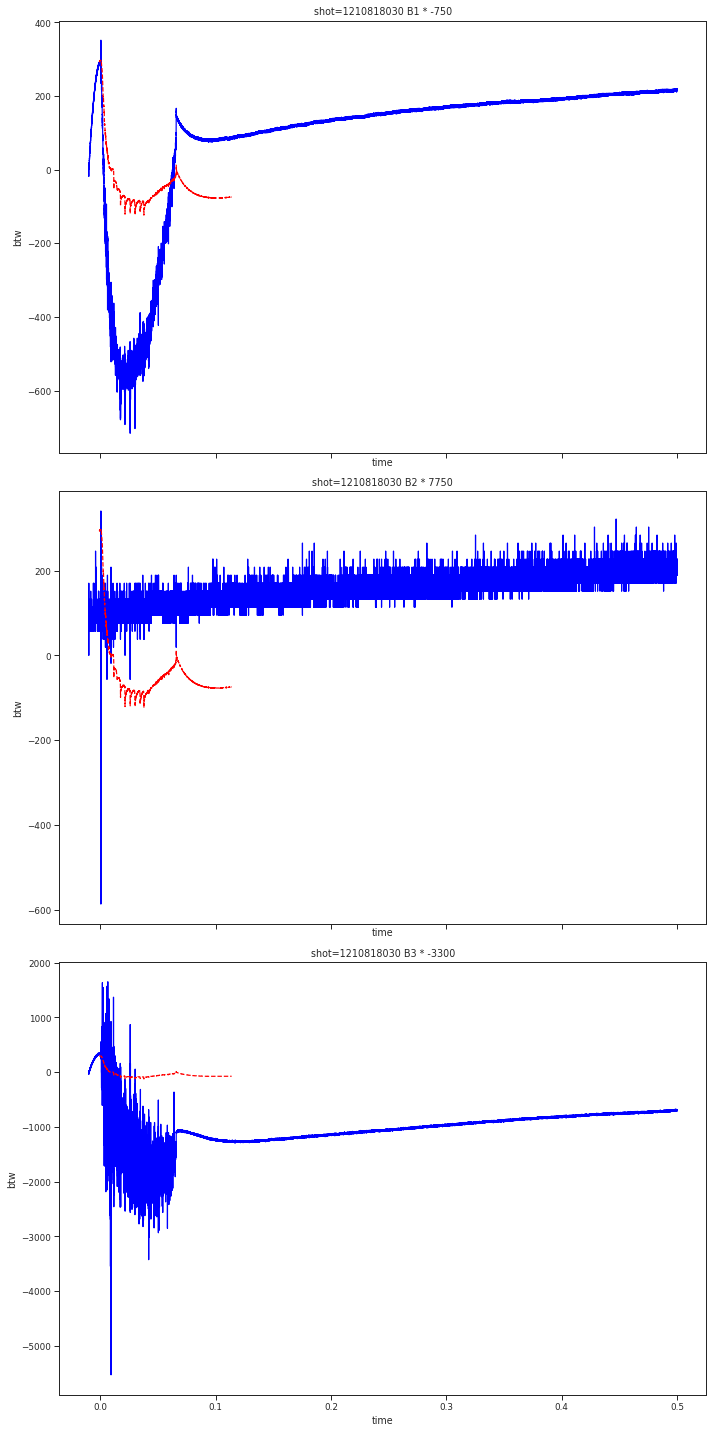

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

for i in [30]:
    #(ds_ops_vac.btave.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[0], color="orange", ls=':')  
    (ds_B.B1.sel(time=slice(-0.01, 0.5), shot=i)*-750).plot(ax=axes[0], color="blue")
    (mst_ds.btw.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[0], color="red", ls='--')  
    
    (ds_B.B2.sel(time=slice(-0.01, 0.5), shot=i)*7750).plot(ax=axes[1], color="blue")  
    (mst_ds.btw.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[1], color="red", ls='--')
    (ds_B.B3.sel(time=slice(-0.01, 0.5), shot=i)*-3300).plot(ax=axes[2], color="blue") 
    (mst_ds.btw.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[2], color="red", ls='--')  

axes[0].set_title("shot=1210818030 B1 * -750")
axes[1].set_title("shot=1210818030 B2 * 7750")
axes[2].set_title("shot=1210818030 B3 * -3300")

plt.tight_layout()
plt.savefig("btw-bdot-1210818030.png")
plt.show()

# Adjust integrator drift

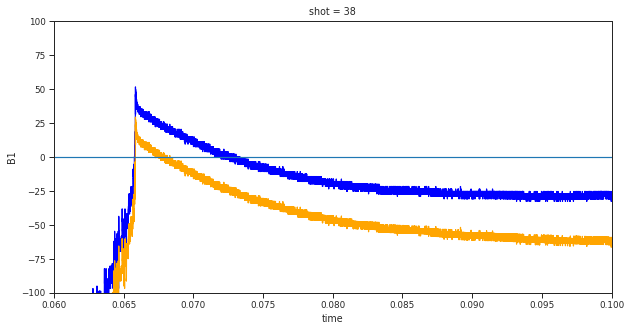

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
(ds_B.B1.sel(time=slice(-0.01, 0.5), shot=38)*-750).plot(ax=axes, color="blue")

adjust = np.zeros(ds_B.time.size)
zero_index = np.where(ds_B.time > 0)[0][0]
adjust[zero_index:] = -0.45*ds_B.time[zero_index:]

B1_dedrifted = ds_B.B1.sel(shot=38) - adjust
plt.plot(ds_B.time, B1_dedrifted*-750, color='orange')


#(mst_ds.btw.sel(time=slice(-10, 0.5), shot=38)).plot(ax=axes, color="red", ls='--')  


plt.xlim(0.06, 0.1)
plt.ylim(-100, 100)
plt.axhline(0)

  


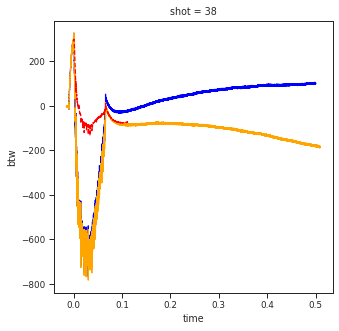

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)
(ds_B.B1.sel(time=slice(-0.01, 0.5), shot=i)*-750).plot(ax=axes, color="blue")

adjust = np.zeros(ds_B.time.size)
zero_index = np.where(ds_B.time > 0)[0][0]
adjust[zero_index:] = -0.75*ds_B.time[zero_index:]

B1_dedrifted = ds_B.B1.sel(shot=38) - adjust
plt.plot(ds_B.time, B1_dedrifted*-750, color='orange')


(mst_ds.btw.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes, color="red", ls='--')  


# Stretch Ip

In [32]:
ip = mst_ds.ip.sel(shot=38).values 
ip_stretch = np.zeros(ds_B.time.values.size)
time_to_stretch = mst_ds.time.values 
for i, time in enumerate(ds_B.time.values):
    index = np.abs(time_to_stretch - time).argmin()
    ip_stretch[i] = ip[index]

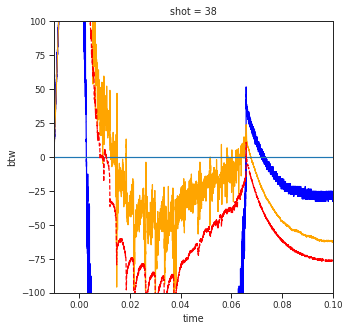

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)
(ds_B.B1.sel(time=slice(-0.01, 0.5), shot=38)*-750).plot(ax=axes, color="blue")

adjust = np.zeros(ds_B.time.size)
zero_index = np.where(ds_B.time > 0)[0][0]
adjust[zero_index:] = -0.45*ds_B.time[zero_index:]

B1_dedrifted = ds_B.B1.sel(shot=38) - adjust
B1_adjusted = -750*B1_dedrifted + 2.75*ip_stretch
B1_adjusted = xr.apply_ufunc(convolve, B1_adjusted, 100)

plt.plot(ds_B.time, B1_adjusted, color='orange')

plt.xlim(-0.01, 0.1)
plt.ylim(-100, 100)
plt.axhline(0)

(mst_ds.btw.sel(time=slice(-10, 0.5), shot=38)).plot(ax=axes, color="red", ls='--')  

# Discharge Reproducibility (I_p and n_e)

(-0.01, 0.07)

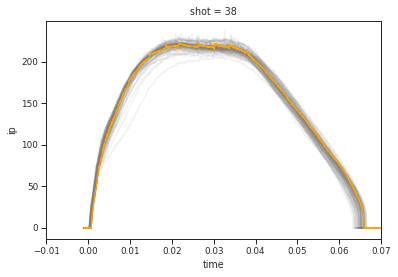

In [34]:
fig, axes = plt.subplots()
mst_ds.ip.sel({'shot':38}).plot(color='orange')
for i in range(7,83):
    mst_ds.ip.sel({'shot':i}).plot(color='gray', alpha=0.1)
mst_ds.ip.sel({'shot':38}).plot(color='orange')
axes.set_xlim((-10e-3, 70e-3))

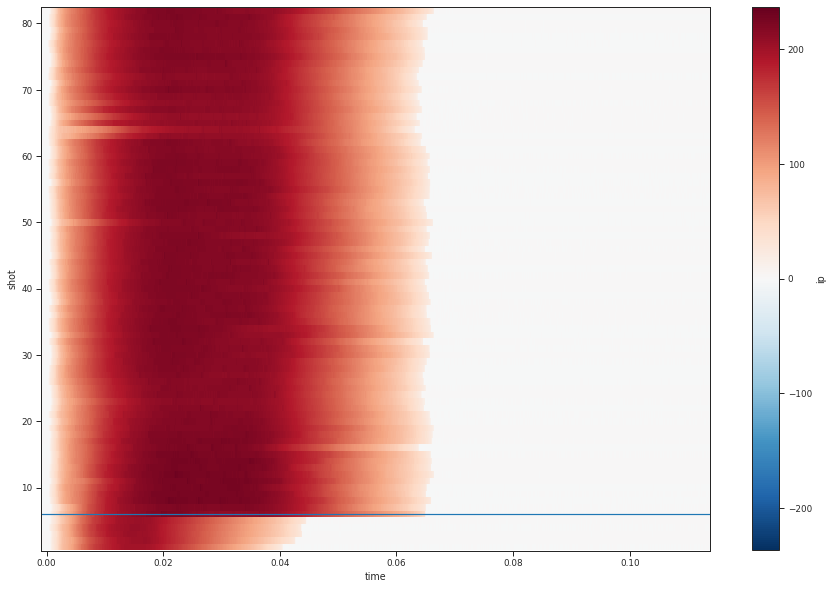

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))
mst_ds.ip.plot()
axes.axhline(6)

In [36]:
mst_ds.ip.sel({'shot': slice(11, 83), 'time': slice(0.02, 0.04)}).mean(dim='shot').std()

<xarray.DataArray 'ip' ()>
array(4.24296409)

In [37]:
mst_ds.ip.sel({'shot': slice(11, 83), 'time': slice(0.02, 0.040)}).mean(dim='shot').mean()

<xarray.DataArray 'ip' ()>
array(215.0094382)

In [38]:
(mst_ds.ip.sel({'shot': slice(11, 83), 'time': slice(0.02, 0.040)}).mean(dim='shot').std() /
 mst_ds.ip.sel({'shot': slice(11, 83), 'time': slice(0.02, 0.040)}).mean(dim='shot').mean())

<xarray.DataArray 'ip' ()>
array(0.01973385)

In [39]:
mst_ne_ds.ne.sel({'shot': slice(11, 83), 'time': slice(20, 40)}).mean(dim='shot').mean()

<xarray.DataArray 'ne' ()>
array(0.8602043)

In [40]:
mst_ne_ds.ne.sel({'shot': slice(11, 83), 'time': slice(20, 40)}).mean(dim='shot').std()

<xarray.DataArray 'ne' ()>
array(0.01690927)

In [41]:
(mst_ne_ds.ne.sel({'shot': slice(11, 83), 'time': slice(20, 40)}).mean(dim='shot').std() /
 mst_ne_ds.ne.sel({'shot': slice(11, 83), 'time': slice(20, 40)}).mean(dim='shot').mean())

<xarray.DataArray 'ne' ()>
array(0.01965727)

# Fig 4

In [42]:
mst_ds = mst_ds.assign_coords({'ms': mst_ds.time*1e3})
ds_B = ds_B.assign_coords({'ms': ds_B.time*1e3})
mst_btwf_ds =  mst_btwf_ds.assign_coords({'ms': mst_btwf_ds.time*1e3})

mst_btwf_ds

<xarray.Dataset>
Dimensions:  (shot: 72, time: 12884)
Coordinates:
  * time     (time) float64 -0.015 -0.01499 -0.01498 ... 0.1138 0.1138 0.1138
  * shot     (shot) int64 11 12 13 14 15 16 17 18 19 ... 75 76 77 78 79 80 81 82
    ms       (time) float64 -15.0 -14.99 -14.98 -14.97 ... 113.8 113.8 113.8
Data variables:
    btw_f    (shot, time) float64 0.071 0.071 0.071 ... -74.44 -74.44 -74.44

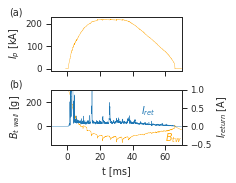

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(3.37, 2.5), sharex=True)
axtwin = axes[1].twinx()

#axtwin.tick_params(axis='y', which='major', right=True, labelright=True, left=False)


mst_ds['ip'].sel(shot=38).plot(ax=axes[0], x='ms', lw=0.4, color='orange')

mst_ds['btw'].sel(shot=38).plot(ax=axes[1], x='ms', lw=0.4, color='orange', label=r"$B_{t \enspace w}$")
I_ret = ds_I['Isat7'].sel(shot=38).plot(ax=axtwin, x='ms', lw=0.4, label="I_{ret}")

axes[0].set_xlim((-10, 70))
axes[0].set_title('')
axes[0].set_xlabel('')
axes[1].set_title('')
axes[1].set_xlabel('t [ms]')
axes[0].set_ylabel(r'$I_p$ [kA]')
axes[1].set_ylabel(r'$B_{t \enspace wall}$ [g]')
axtwin.set_ylabel(r'$I_{return}$ [A]')
axtwin.set_xlabel('')
axtwin.set_title('')
axtwin.set_title('')
axtwin.set_ylim((-0.5, 1))
axes[1].set_ylim((-150, 300))
axes[1].text(45, 100, r"$I_{ret}$", color=I_ret[0].get_color())
axes[1].text(60, -120, r"$B_{tw}$", color="orange")

fig.text(0.05, 0.95, '(a)')
fig.text(0.05, 0.55, '(b)')

plt.tight_layout()
plt.savefig('output/plasma_params.eps')

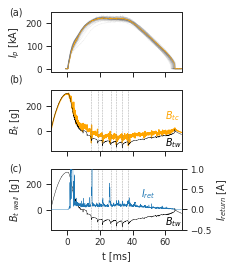

In [47]:
from scipy.signal import find_peaks
prom=10
dist=100

btw = mst_ds['btw'].sel(shot=38)
time = btw.time

peaks, properties = find_peaks(btw.values,distance=dist,prominence=(prom,None))
valleys, properties2 = find_peaks(-1*btw.values,distance=dist,prominence=(prom,None))


fig, axes = plt.subplots(3, 1, figsize=(3.37, 3.75), sharex=True)
axtwin = axes[2].twinx()

#axtwin.tick_params(axis='y', which='major', right=True, labelright=True, left=False)

for i in range(7,83):
    mst_ds.ip.sel({'shot':i}).plot(color='gray', x='ms', alpha=0.1, ax=axes[0], lw=0.4)
mst_ds['ip'].sel(shot=38).plot(ax=axes[0], x='ms', lw=0.4, color='orange')
mst_btwf_ds['btw_f'].sel(shot=38).plot(ax=axes[2], x='ms', lw=0.4, color='black', label=r"$B_{t \enspace w}$", zorder=100)
I_ret = ds_I['Isat7'].sel(shot=38).plot(ax=axtwin, x='ms', lw=0.4, label="I_{ret}", zorder=100)

ip = mst_ds.ip.sel(shot=38).values 
ip_stretch = np.zeros(ds_B.time.values.size)
time_to_stretch = mst_ds.time.values 
for i, time_point in enumerate(ds_B.time.values):
    index = np.abs(time_to_stretch - time_point).argmin()
    ip_stretch[i] = ip[index]

adjust = np.zeros(ds_B.time.size)
zero_index = np.where(ds_B.time > 0)[0][0]
adjust[zero_index:] = -0.45*ds_B.time[zero_index:]
B1_dedrifted = ds_B.B1.sel(shot=38) - adjust
B1_adjusted = -750*B1_dedrifted + 2.75*ip_stretch
B1_adjusted = xr.apply_ufunc(convolve, B1_adjusted, 100)

axes[1].plot(ds_B.ms, B1_adjusted, color='orange')    
mst_btwf_ds['btw_f'].sel(shot=38).plot(ax=axes[1], x='ms', lw=0.4, color='black', label=r"$B_{t \enspace w}$", zorder=100)

axes[0].set_xlim((-10, 70))
axes[0].set_title('')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[1].set_title('')
axes[2].set_title('')
axes[2].set_xlabel('t [ms]')
axes[0].set_ylabel(r'$I_p$ [kA]')
axes[1].set_ylabel(r'$B_{t}$ [g]')
axes[2].set_ylabel(r'$B_{t \enspace wall}$ [g]')
axtwin.set_ylabel(r'$I_{return}$ [A]')
axtwin.set_xlabel('')
axtwin.set_title('')
axtwin.set_title('')
axtwin.set_ylim((-0.5, 1))
axes[2].set_ylim(axes[1].get_ylim())
axes[2].text(45, 100, r"$I_{ret}$", color=I_ret[0].get_color())
axes[2].text(60, -120, r"$B_{tw}$", color="black")
axes[1].text(60, -120, r"$B_{tw}$", color="black")
axes[1].text(60, 100, r"$B_{tc}$", color="orange")


for peak in valleys[1:]:
    axes[2].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7, zorder=1)
    axes[1].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7)

fig.text(0.05, 0.95, '(a)')
fig.text(0.05, 0.7, '(b)')
fig.text(0.05, 0.37, '(c)')

plt.tight_layout()
plt.savefig('output/plasma_params.pdf')

# Fig 5

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(6.69, 6), sharex=True)

(ds_I['Isat1'].sel(shot=38, time=slice(-10e-3, 70e-3))*100).plot(ax=axes[0, 0], x='ms', lw=0.4)
(ds_I['Isat2'].sel(shot=38, time=slice(-10e-3, 70e-3))*100).plot(ax=axes[0, 1], x='ms', lw=0.4)
(ds_I['Isat3'].sel(shot=38, time=slice(-10e-3, 70e-3))*100).plot(ax=axes[1, 0], x='ms', lw=0.4)
(ds_I['Isat4'].sel(shot=38, time=slice(-10e-3, 70e-3))*100).plot(ax=axes[1, 1], x='ms', lw=0.4)
(ds_I['Isat5'].sel(shot=38, time=slice(-10e-3, 70e-3))*100).plot(ax=axes[2, 0], x='ms', lw=0.4)
(ds_I['Isat6'].sel(shot=38, time=slice(-10e-3, 70e-3))*100).plot(ax=axes[2, 1], x='ms', lw=0.4)

(ds_I_smoother['Isat1'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot').plot(ax=axes[0, 0], x='ms')
((ds_I_smoother['Isat1'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 + (ds_I_smoother['Isat1'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[0, 0], x='ms', color='orange', ls='--')
((ds_I_smoother['Isat1'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 - (ds_I_smoother['Isat1'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[0, 0], x='ms', color='orange', ls='--')

(ds_I_smoother['Isat2'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot').plot(ax=axes[0, 1], x='ms')
((ds_I_smoother['Isat2'].sel(shot=slice(30, 39), time=slice(0, 55e-3))*100).mean(dim='shot')
 + (ds_I_smoother['Isat2'].sel(shot=slice(30, 39), time=slice(0, 55e-3))*100).std(dim='shot')).plot(ax=axes[0, 1], x='ms', color='orange', ls='--')
((ds_I_smoother['Isat2'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 - (ds_I_smoother['Isat2'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[0, 1], x='ms', color='orange', ls='--')

(ds_I_smoother['Isat3'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot').plot(ax=axes[1, 0], x='ms')
((ds_I_smoother['Isat3'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 + (ds_I_smoother['Isat3'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[1, 0], x='ms', color='orange', ls='--')
((ds_I_smoother['Isat3'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 - (ds_I_smoother['Isat3'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[1, 0], x='ms', color='orange', ls='--')

(ds_I_smoother['Isat4'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot').plot(ax=axes[1, 1], x='ms')
((ds_I_smoother['Isat4'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 + (ds_I_smoother['Isat4'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[1, 1], x='ms', color='orange', ls='--')
((ds_I_smoother['Isat4'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 - (ds_I_smoother['Isat4'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[1, 1], x='ms', color='orange', ls='--')

(ds_I_smoother['Isat5'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot').plot(ax=axes[2, 0], x='ms')
((ds_I_smoother['Isat5'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 + (ds_I_smoother['Isat5'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[2, 0], x='ms', color='orange', ls='--')
((ds_I_smoother['Isat5'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 - (ds_I_smoother['Isat5'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[2, 0], x='ms', color='orange', ls='--')

(ds_I_smoother['Isat6'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot').plot(ax=axes[2, 1], x='ms')
((ds_I_smoother['Isat6'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 + (ds_I_smoother['Isat6'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[2, 1], x='ms', color='orange', ls='--')
((ds_I_smoother['Isat6'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).mean(dim='shot')
 - (ds_I_smoother['Isat6'].sel(shot=slice(30, 39), time=slice(-10e-3, 70e-3))*100).std(dim='shot')).plot(ax=axes[2, 1], x='ms', color='orange', ls='--')

axes[0, 0].set_title(r'$I_1$ [mA]')
axes[0, 1].set_title(r'$I_2$ [mA]')
axes[1, 0].set_title(r'$I_3$ [mA]')
axes[1, 1].set_title(r'$I_4$ [mA]')
axes[2, 0].set_title(r'$I_5$ [mA]')
axes[2, 1].set_title(r'$I_6$ [mA]')

axes[0, 0].set_ylabel('')
axes[1, 0].set_ylabel('')
axes[2, 0].set_ylabel('')
axes[0, 1].set_ylabel('')
axes[1, 1].set_ylabel('')
axes[2, 1].set_ylabel('')

axes[0, 0].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[2, 0].set_xlabel('t [ms]')
axes[0, 1].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[2, 1].set_xlabel('t [ms]')

axes[0, 0].set_ylim((-0.01, 6))
axes[1, 0].set_ylim((-0.01, 6))
axes[2, 0].set_ylim((-0.01, 6))
axes[0, 1].set_ylim((-0.01, 6))
axes[1, 1].set_ylim((-0.01, 6))
axes[2, 1].set_ylim((-0.01, 6))

axes[0, 0].set_xlim((-10, 70))
axes[1, 0].set_xlim((-10, 70))
axes[2, 0].set_xlim((-10, 70))
axes[0, 1].set_xlim((-10, 70))
axes[1, 1].set_xlim((-10, 70))
axes[2, 1].set_xlim((-10, 70))

for peak in valleys[1:]:
    axes[0, 0].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7, zorder=1)
    axes[1, 0].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7, zorder=1)
    axes[2, 0].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7, zorder=1)
    axes[0, 1].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7, zorder=1)
    axes[1, 1].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7, zorder=1)
    axes[2, 1].axvline(time[peak]*1e3, ls="--", lw=0.5, color="gray", alpha=0.7, zorder=1)


fig.text(0.02, 0.95, '(a)')
fig.text(0.52, 0.95, '(b)')
fig.text(0.02, 0.65, '(c)')
fig.text(0.52, 0.65, '(d)')
fig.text(0.02, 0.35, '(e)')
fig.text(0.52, 0.35, '(f)')

plt.tight_layout()
plt.savefig('output/saturation_currents.eps')